# Overview {#sec-annoclass}

This notebook has been adapted from machine learning workshop by Esam Ghaleb (see [Github repository](https://github.com/EsamGhaleb/MachineLearningBasics)), and adapted mostly by Hamza Nalbantoglu.

In this notebook, we train a movement classifier using logistic regression. We train four models for four tiers of movement - head, arms, upper body, and lower body. The training datasets have been prepared in the [previous script](../04_TS_movementAnnotation/01_Classify_preparation.ipynb#sec-annoprep).

Afterwards, we use the models to annotate the original timeseries data that have been prepared in the [previous script](../04_TS_movementAnnotation/01_Classify_preparation.ipynb#sec-annoprep). The timeseries data have been adapted to the same format as the training data, and contain overlapping time windows of 25 ms. We use these overlaps to build a continuum consisting of the model's confidence, and use a threshold of the confidence to determine whether the movement is present or not.

In [2]:
#| code-fold: true
#| code-summary: Code to prepare the environment

import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib
warnings.filterwarnings("ignore")

curfolder = os.getcwd()

# Here we store training data
trainingfolder = curfolder + '\\TrainingData\\'
# Here we store data for classifying
classifyingfolder = curfolder + '\\TS_forClassifying\\'
# Here we store models
modelsfolder = curfolder + '\\Models\\'


# Training a classifier

We train the model on four tiers separately - head, arms, upper body, lower body - as they were annotated in this way manually by human annotators. The `train_test_split` function is used to split the data into training (75% of the data) and testing sets (25%). The training set is used to train the model, and the testing set is used to evaluate the model's performance.

In [3]:
#| code-fold: true
#| code-summary: Functions to classify movement

# Class of functions for classifier
class MovementClassifier:
    """
    The only argument is the path to the dataset.
    """
    def __init__(self, csv_file_path):
        self.df = pd.read_csv(csv_file_path)
        self.df['anno_value'] = self.df['anno_value'].astype(str).str.strip()
        self.label_encoder = LabelEncoder()
        self.model = LogisticRegression()
        self.scaler = StandardScaler()
        self.min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

    def preprocess_data(self, X, y):
        # Replace NaN values with 0
        X = np.nan_to_num(X) 
        # Standardize the features
        X = self.scaler.fit_transform(X)
        # Normalize features to lie in [-1, 1]
        X = self.min_max_scaler.fit_transform(X)
        # Encode the labels
        y = self.label_encoder.fit_transform(y)
        return X, y

    def evaluate_and_plot(self, feature_type, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
        self.model.fit(X_train, y_train)
        
        train_score = self.model.score(X_train, y_train)
        test_score = self.model.score(X_test, y_test)
        
        print('This is the evaluation of the model')
        print(f"\n{feature_type} Features")
        print(f"Accuracy on training set: {train_score}")
        print(f"Accuracy on test set: {test_score}")
        
        y_pred = self.model.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix")
        print(conf_matrix)
        
        gesture_names = self.label_encoder.inverse_transform(np.unique(y_test))
        
        sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=gesture_names, yticklabels=gesture_names)
        plt.title(f'Confusion Matrix for {feature_type} Features')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        print("Classification Report")
        print(classification_report(y_test, y_pred, target_names=gesture_names))

    def load_and_process_data(self, X_columns, y_column):
        X = self.df.iloc[:, X_columns].values
        y = self.df[y_column].values
        X, y = self.preprocess_data(X, y)
        return X, y

## Arm model

This is the evaluation of the model

All Features
Accuracy on training set: 0.9760348583877996
Accuracy on test set: 0.9575163398692811
Confusion Matrix
[[237  18]
 [  8 349]]


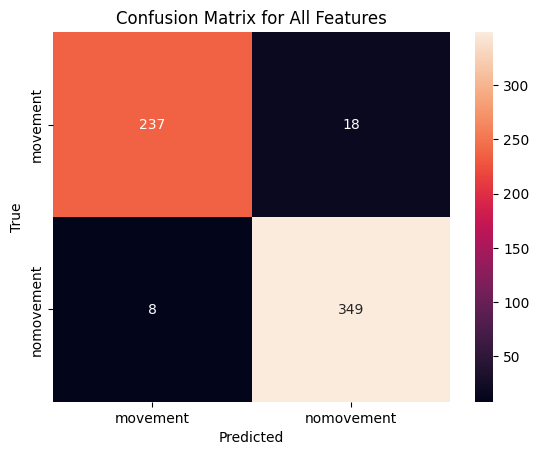

Classification Report
              precision    recall  f1-score   support

    movement       0.97      0.93      0.95       255
  nomovement       0.95      0.98      0.96       357

    accuracy                           0.96       612
   macro avg       0.96      0.95      0.96       612
weighted avg       0.96      0.96      0.96       612



['e:\\FLESH_ContinuousBodilyEffort\\04_TS_movementAnnotation\\Models\\model_arms.pkl']

In [4]:
#| eval: false

# Load arm data
csv_path = trainingfolder + 'dataset_arms_features.csv'

# Create a MovementClassifier object
model_arms = MovementClassifier(csv_path)

# load in the model
model_path = modelsfolder + 'model_arms.pkl'
model_arms = joblib.load(model_path)

# Load features
feature_indices = list(range(model_arms.df.shape[1] - 3))

# Load the feature and label data
X, y = model_arms.load_and_process_data(X_columns=feature_indices, y_column='anno_value')

# Evaluate and plot using the selected features
model_arms.evaluate_and_plot("All", X, y)

# Save the model
model_path = modelsfolder + 'model_arms.pkl'
joblib.dump(model_arms, model_path)

## Head model

This is the evaluation of the model

All Features
Accuracy on training set: 0.9368146214099217
Accuracy on test set: 0.863849765258216
Confusion Matrix
[[243  29]
 [ 58 309]]


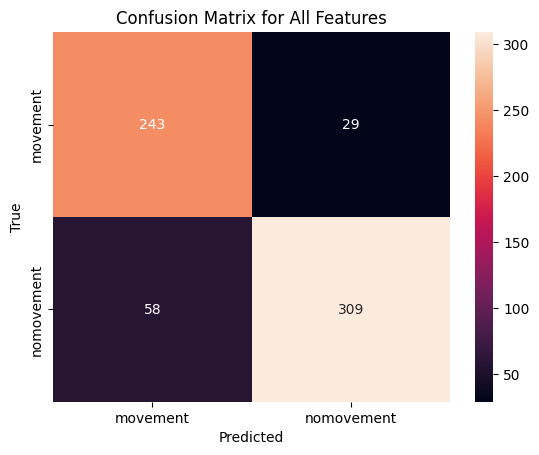

Classification Report
              precision    recall  f1-score   support

    movement       0.81      0.89      0.85       272
  nomovement       0.91      0.84      0.88       367

    accuracy                           0.86       639
   macro avg       0.86      0.87      0.86       639
weighted avg       0.87      0.86      0.86       639



['e:\\FLESH_ContinuousBodilyEffort\\04_TS_movementAnnotation\\Models\\model_head_mov.pkl']

In [5]:
#| eval: false

# Load head data
csv_path = trainingfolder + 'dataset_head_mov_features.csv'

# Create a MovementClassifier object
model_head = MovementClassifier(csv_path)

# load in the model
model_path = modelsfolder + 'model_head_mov.pkl'
model_head = joblib.load(model_path)

# Load features
feature_indices = list(range(model_head.df.shape[1] - 3))

# Load the feature and label data
X, y = model_head.load_and_process_data(X_columns=feature_indices, y_column='anno_value')

# Evaluate and plot using the selected features
model_head.evaluate_and_plot("All", X, y)

# Save the model
model_path = modelsfolder + 'model_head_mov.pkl'
joblib.dump(model_head, model_path)

## Upper body model

This is the evaluation of the model

All Features
Accuracy on training set: 0.9372409709887507
Accuracy on test set: 0.8632326820603907
Confusion Matrix
[[171  37]
 [ 40 315]]


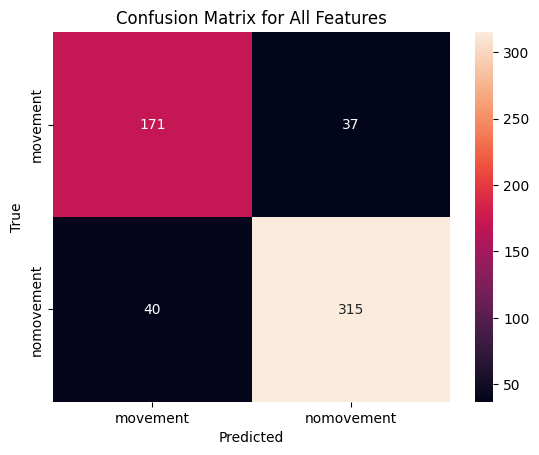

Classification Report
              precision    recall  f1-score   support

    movement       0.81      0.82      0.82       208
  nomovement       0.89      0.89      0.89       355

    accuracy                           0.86       563
   macro avg       0.85      0.85      0.85       563
weighted avg       0.86      0.86      0.86       563



['e:\\FLESH_ContinuousBodilyEffort\\04_TS_movementAnnotation\\Models\\model_upper_body.pkl']

In [6]:
#| eval: false

# Load upper body data
csv_path = trainingfolder + 'dataset_upper_body_features.csv'

# Create a MovementClassifier object
model_upper = MovementClassifier(csv_path)

# load in the model
model_path = modelsfolder + 'model_upper_body.pkl'
model_upper = joblib.load(model_path)

# Load features
feature_indices = list(range(model_upper.df.shape[1] - 3))

# Load the feature and label data
X, y = model_upper.load_and_process_data(X_columns=feature_indices, y_column='anno_value')

# Evaluate and plot using the selected features
model_upper.evaluate_and_plot("All", X, y)

# Save the model
model_path = modelsfolder + 'model_upper_body.pkl'
joblib.dump(model_upper, model_path)

## Lower body model

This is the evaluation of the model

All Features
Accuracy on training set: 0.9594921402660218
Accuracy on test set: 0.8913043478260869
Confusion Matrix
[[165  33]
 [ 27 327]]


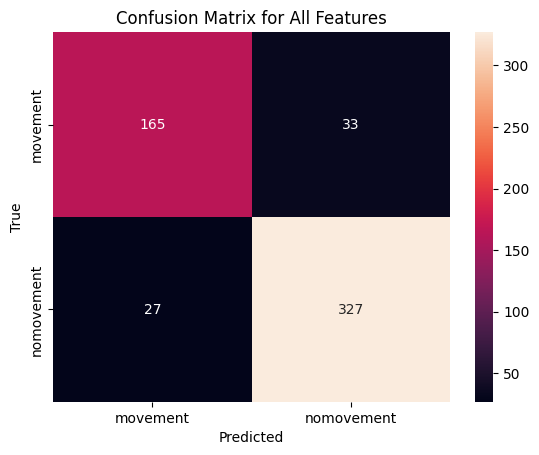

Classification Report
              precision    recall  f1-score   support

    movement       0.86      0.83      0.85       198
  nomovement       0.91      0.92      0.92       354

    accuracy                           0.89       552
   macro avg       0.88      0.88      0.88       552
weighted avg       0.89      0.89      0.89       552



['e:\\FLESH_ContinuousBodilyEffort\\04_TS_movementAnnotation\\Models\\model_lower_body.pkl']

In [7]:
#| eval: true

# Load lower body data
csv_path = trainingfolder + 'dataset_lower_body_features.csv'

# Create a MovementClassifier object
model_lower = MovementClassifier(csv_path)

# load in the model
model_path = modelsfolder + 'model_lower_body.pkl'
model_lower = joblib.load(model_path)

# Load features
feature_indices = list(range(model_lower.df.shape[1] - 3))

# Load the feature and label data
X, y = model_lower.load_and_process_data(X_columns=feature_indices, y_column='anno_value')

# Evaluate and plot using the selected features
model_lower.evaluate_and_plot("All", X, y)

# Save the model
model_path = modelsfolder + 'model_lower_body.pkl'
joblib.dump(model_lower, model_path)

# Applying classifier to timeseries data

Now we have trained model to classify a chunk into movement or no-movement. We will apply the model (per each tier separately) to the timeseries data that we prepared into consecutive chunks with sliding step of 25 ms in the previous script.

We will also generate a confidence of the model per each chunk, and average the confidence for overlapping sections to get confidence for a label as a time-varying signal over the length of each trial.

In [8]:
#| code-fold: true
#| code-summary: Custom functions

# Function to average the confidence values for each time point and create continuous confidence-timeline
def generate_continuous_timeline(df, max_time, segment_duration=100, shift=24):
    # Prepare a timeseries of a length equal to the trial duration
    timeline = np.arange(0, max_time + 1)

    continuous_probabilities = []

    # A loop to calculate the average confidence level at each millisecond:
    for t in timeline:
        # Find the segments that overlap with this time point:
        overlapping_segments = df[(df['start_time'] <= t) & (df['start_time'] + segment_duration > t)]
        
        # Average the confidence levels of these overlapping segments
        if not overlapping_segments.empty:
            avg_confidence = overlapping_segments['confidence_movement'].mean()
        else:
            avg_confidence = np.nan  # If there is no data at this millisecond

        continuous_probabilities.append(avg_confidence)

    # Replace the first and last 150 ms of probabilities with zeros to avoid edge bumps (we know anyway there is always a no movement in the beginning and in the end)
    change_duration = 150
    continuous_probabilities[:change_duration] = [0] * change_duration
    continuous_probabilities[-change_duration:] = [0] * change_duration

    # Create a df for the continuous probability timeline
    continuous_timeline = pd.DataFrame({'time_ms': timeline, 'confidence_movement': continuous_probabilities})

    # Fill NaN values throughout using forward-fill (fill with last value) or backward-fill (fill with next value)
    continuous_timeline['confidence_movement'] = continuous_timeline['confidence_movement'].ffill().bfill()

    return continuous_timeline

# Function to smooth the continuous timeline of confidence scores using a moving average with a fixed window size
def smooth_timeline(continuous_timeline, window_size=300):

    # Applying smoothing with the specified window size (using ".rolling()" method from pandas)
    # "min_periods = 1": at least one value in the window should have a value.
    # "center = True": centers the window around the points.
    continuous_timeline['smoothed_confidence'] = continuous_timeline['confidence_movement'].rolling(window=window_size, min_periods=1, center=True).mean()
    
    return continuous_timeline

In [ ]:
#| eval: false

# This is were we store the predictions per trial (per tier)
predictedfolder = curfolder + '\\TS_predicted_workingfiles\\'

# These are the models we are applying
models = ['arms', 'head_mov', 'upper_body', 'lower_body']

for model in models:
    # Load in the original df
    original_df = pd.read_csv(trainingfolder + f'dataset_{model}_features.csv')

    # Load in the model
    gesture_model = joblib.load(modelsfolder + f'model_{model}.pkl')

    # Loop through each file in the folder...
    for filename in os.listdir(classifyingfolder):
        
        # Making sure it's a correct CSV file:
        if filename.endswith('chunked.csv'):
            
            try:
                # Load in the chunked timeseries
                csv_path = os.path.join(classifyingfolder, filename)
                new_df = pd.read_csv(csv_path)
                
                # This is the max time
                max_time = int(new_df['end_time'].iloc[-1])

                # Get cols that are in new_df but not in original_df - otherwise regression model throws an error
                extra_cols = [col for col in new_df.columns if col not in original_df.columns]

                # Create df from new_df with only the columns that are in original_df
                clean_df = new_df[[col for col in new_df.columns if col not in extra_cols]]

                # Reordering df1 columns to match df2
                clean_df_reordered = new_df.reindex(columns=original_df.columns)

                # Final clean
                clean_df_reordered = clean_df_reordered.drop(columns=['anno_value'])
                clean_df_reordered = clean_df_reordered.iloc[:, :-2]

                # Apply classifier
                new_X = clean_df_reordered.values
                new_X = gesture_model.scaler.transform(new_X)
                new_X = gesture_model.min_max_scaler.transform(new_X)

                predictions = gesture_model.model.predict(new_X)
                probabilities = gesture_model.model.predict_proba(new_X)

                predicted_labels = gesture_model.label_encoder.inverse_transform(predictions)
                results_df = pd.DataFrame({
                    'start_time': new_df['start_time'],
                    'predicted_labels': predicted_labels,
                    'confidence_movement': [prob[0] for prob in probabilities]
                })

                # Generate a continuous timeline
                df_continuous = generate_continuous_timeline(results_df, max_time)

                # Smooth
                df_smoothed = smooth_timeline(df_continuous)

                input_filename = os.path.splitext(filename)[0]
                output_filename = input_filename.replace('chunked', 'predicted_smoothed_confidence.csv')
                # Create folder in predictedfolder for model
                if not os.path.exists(predictedfolder + f'\\{model}\\'):
                    os.makedirs(predictedfolder + f'\\{model}\\')
                
                # Save it
                output_path = os.path.join(predictedfolder + f'\\{model}\\' + output_filename)
                df_smoothed.to_csv(output_path, index=False)
                print(f'Processed and saved: {output_filename}')

            except Exception as e:
                print(f'Error processing file {filename}: {e}')


Now we have each timeseries saved as a variable that states the confidence of the behaviour being a movement or not (1 is movement, 0 is no movement). We can see in the plots below how does the confidence look like on five randomly picked trials.

In [15]:
#| code-fold: true
#| code-summary: Custom functions

# Function to plot confidence
def plot_smooth_confidence_timeline(filename, folder_path):

    try:
        # Construct the full path to the file and load the data:
        file_path = os.path.join(folder_path, filename)
        filename = os.path.basename(file_path).split('_')[0:5]
        # Concatenate the first 5 elements of the filename to create a title
        filename = '_'.join(filename)

        timeline = pd.read_csv(file_path)

        # Plot the timeline:
        plt.figure(figsize=(8, 5))
        plt.plot(timeline['time_ms'], timeline['confidence_movement'], label='Continuous', alpha=0.5)
        plt.plot(timeline['time_ms'], timeline['smoothed_confidence'], label='Smoothed', linewidth=2)
        # Add red horizontal line at y = 0.8    # Example threshold 1
        plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1)
        # Add purple horizontal line at y = 0.6    # Example threshold 2
        plt.axhline(y=0.6, color='purple', linestyle='--', linewidth=1)
        plt.xlabel('Time (ms)')
        plt.ylabel('Confidence Movement Probability')
        plt.ylim(0, 1.1)  # Set y-axis limits between 0 and 1.1 for better visualization 
        plt.legend()
        plt.title(f'Confidence Level Timeline for Movement Predictions: {filename}')
        plt.show()

    except Exception as e:
        print(f'Error processing file {filename}: {e}')

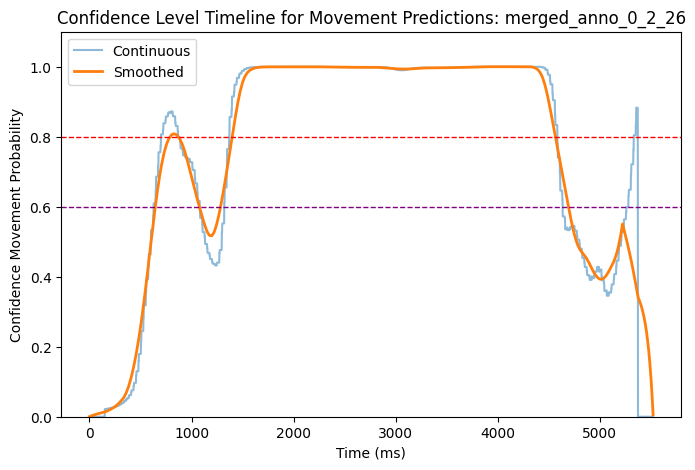

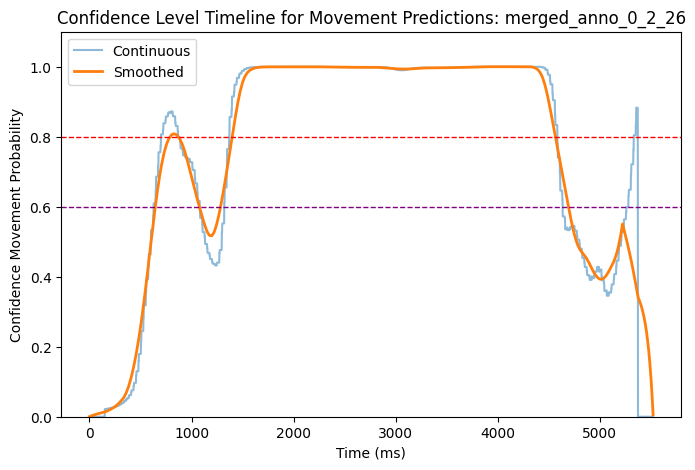

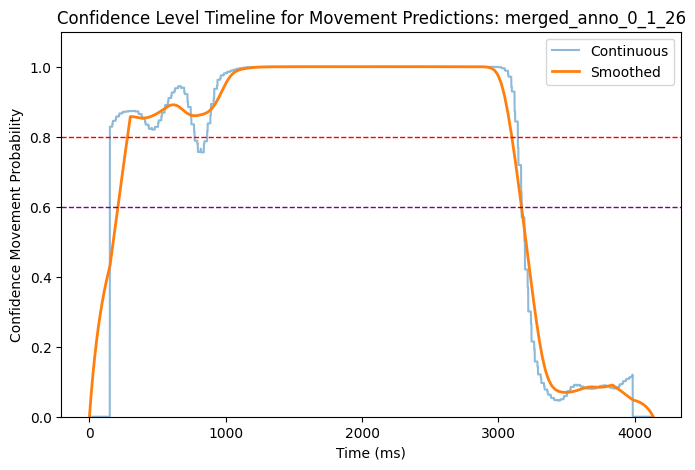

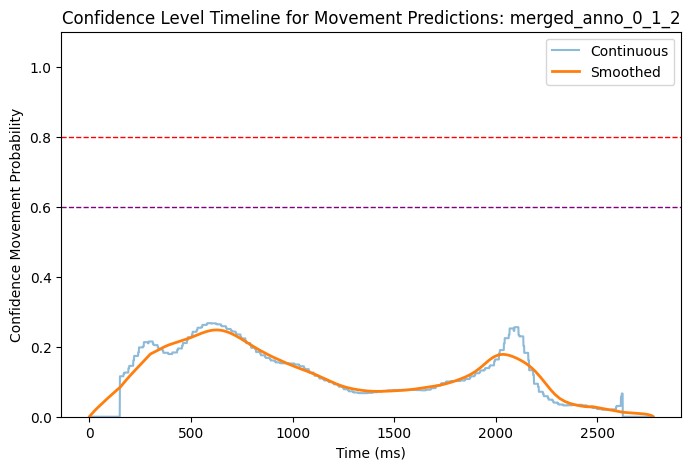

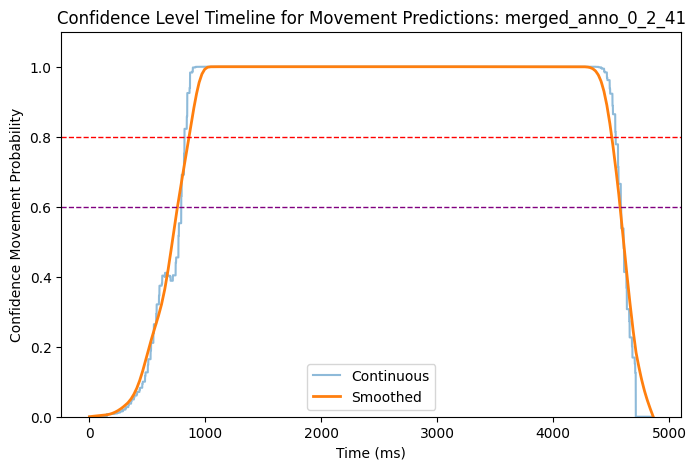

In [16]:
#| echo: false

# Pick 5 random files from files predicted for arm movement
folder_path = curfolder + '\\TS_predicted_workingfiles\\arms\\'
files = glob.glob(folder_path + '*.csv')
files = np.random.choice(files, 5)

# Plot them
for filename in files:
    plot_smooth_confidence_timeline(filename, folder_path)
    

We can check back to the original videos how does the predictions fit to the actual occurence of movement in trial. We can now set a threshold to determine which confidence level is enough to say that movement is present. We will try two different threshold - 60% and 80% - to test the sensitivity of the model, and compare the annotations created with these two thresholds against the manual annotations (see [next script](../04_TS_movementAnnotation/03_InterAgreement.ipynb#sec-annoia)).

In [12]:
#| code-fold: true
#| code-summary: Custom functions

# Function to annotate trials based on the confidence threshold
def annotate_files(tier, folder_path, annotated_path, threshold):
    # Create a new folder path based on the threshold value
    threshold_str = f"{threshold}".replace(".", "_")  
    new_foldername = f"{tier}_annotations_threshold_{threshold_str}" 
    new_folder_path = os.path.join(annotated_path, new_foldername)

    # Create the new folder in annotated path
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    files = glob.glob(folder_path + '*.csv')

    for filename in files:
        if filename.endswith("smoothed_confidence.csv"): 
            print(f"Processing file: {filename}")
            file_path = os.path.join(folder_path, filename)
            filename = os.path.basename(file_path)

            # Load the CSV file
            df = pd.read_csv(file_path)
            
            # Add an 'anno_values' column with annotations based on 'smoothed_confidence' values and threshold
            df['anno_values'] = df['smoothed_confidence'].apply(lambda x: 'movement' if x > threshold else 'no movement')
            
            # Create a new file
            new_filename = filename.replace("predicted_smoothed_confidence.csv", f"annotated_threshold_{threshold_str}.csv")
            output_path = os.path.join(new_folder_path, new_filename)
            
            # Save it
            df.to_csv(output_path, index=False)

In [ ]:
#| eval: false

# Here we store the predicted values with confidence per trial (and tier)
folder_path = curfolder + '\\TS_predicted_workingfiles\\'
# Here we store the trials annotated by the model
annotated_path = curfolder + '\\TS_annotated_logreg\\'

tiers = ['arms', 'head_mov', 'upper_body', 'lower_body']

for tier in tiers:
    folder_path_tier = folder_path + f'{tier}\\'

    # Annotate with threshold 60%
    threshold = 0.6
    annotate_files(tier, folder_path_tier, annotated_path, threshold)

    # Annotate with threshold 80%
    threshold = 0.8
    annotate_files(tier, folder_path_tier, annotated_path, threshold)

Below, you can see how now each trial looks like in terms of the movement annotated by the model on five randomly picked files.

In [17]:
#| code-fold: true
#| code-summary: Custom functions

# Function to plot annotated trial
def plot_movement_timeline(folder_path, filename):
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)

    if 'time_ms' not in df.columns or 'anno_values' not in df.columns:
        print(f"Error: Required columns missing in {filename}")
        return

    df['movement_binary'] = df['anno_values'].apply(lambda x: 1 if x == "movement" else 0)

    # Convert columns to numeric
    df['time_ms'] = pd.to_numeric(df['time_ms'], errors='coerce')
    df['movement_binary'] = pd.to_numeric(df['movement_binary'], errors='coerce')

    # Drop NaN rows
    df.dropna(subset=['time_ms', 'movement_binary'], inplace=True)

    # Plot
    plt.figure(figsize=(8, 3))
    plt.plot(df['time_ms'], df['movement_binary'], color="orange", linewidth=2)
    plt.fill_between(df['time_ms'], df['movement_binary'], color="orange", alpha=0.3, label="Movement")
    
    plt.yticks([0, 1], ['No Movement', 'Movement'])
    plt.xlabel("Time (ms)")
    plt.title("Movement Timeline")
    plt.legend()
    plt.show()


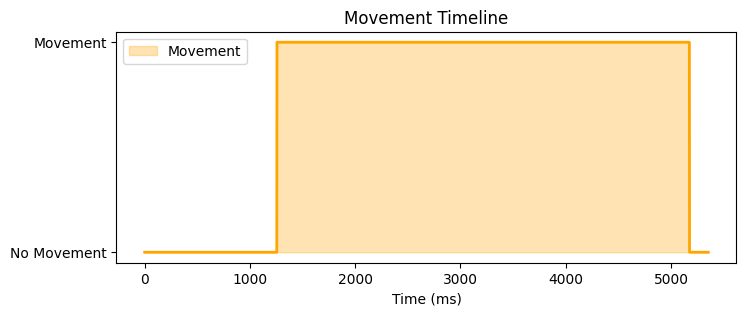

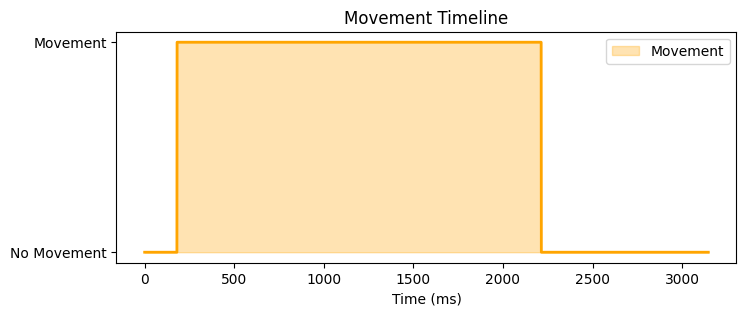

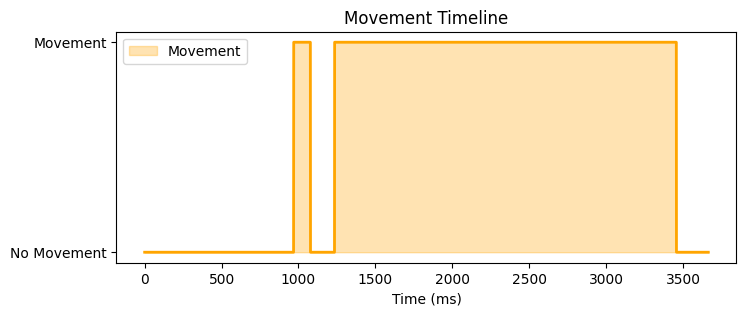

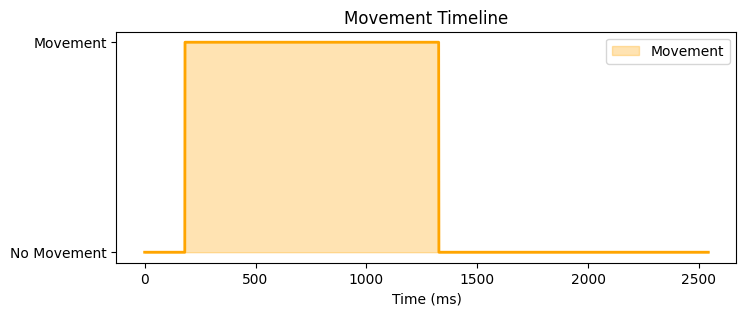

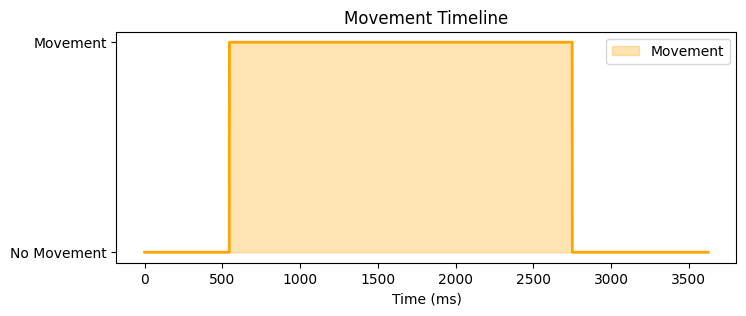

In [18]:
#| echo: false

# This is where arm annotations are stored
folder_path = curfolder + '\\TS_annotated_logreg\\arms_annotations_threshold_0_6\\'

# Plot 5 random files
files = glob.glob(folder_path + '*.csv')
files = np.random.choice(files, 5)

# Plot them
for filename in files:
    plot_movement_timeline(folder_path, filename)
    

In the [following script](../04_TS_movementAnnotation/03_InterAgreement.ipynb#sec-annoia), we will compare the annotations created by the model (with both confidence thresholds) against the manual annotations in order to (1) validate the automatic annotations, and (2) decide which threshold to use for the final annotations.